In [1]:
import awkward as ak
import numpy as np
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

In [2]:
import mplhep
import matplotlib.pyplot as plt
import hist
import mplhep
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['grid.color'] = "#CCCCCC"
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['figure.edgecolor'] = 'none'

In [3]:
# Load 10k events from 2018 signal
fname = "root://xrootd.cmsaf.mit.edu:1094///store/mc/RunIISummer20UL18NanoAODv9/GluGluToHHTo4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2810000/2207F5D6-4518-F44A-8C92-68E712CAF67C.root"
events = NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema, entry_stop=10000).events()

In [4]:
events

<NanoEventsArray [<event 1:34:33001>, ... ] type='10000 * event'>

In [5]:
events.fields

['btagWeight',
 'run',
 'SoftActivityJetHT',
 'HLT',
 'LHEPart',
 'SoftActivityJetHT5',
 'genWeight',
 'SoftActivityJetNjets2',
 'GenVtx',
 'event',
 'GenJet',
 'GenPart',
 'luminosityBlock',
 'CorrT1METJet',
 'OtherPV',
 'boostedTau',
 'PSWeight',
 'Flag',
 'CaloMET',
 'L1PreFiringWeight',
 'SoftActivityJetNjets10',
 'LowPtElectron',
 'Tau',
 'SubJet',
 'SV',
 'Muon',
 'GenMET',
 'LHE',
 'FsrPhoton',
 'L1Reco',
 'RawPuppiMET',
 'LHEWeight',
 'L1simulation',
 'RawMET',
 'DeepMETResolutionTune',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'LHEScaleWeight',
 'SoftActivityJetHT10',
 'SoftActivityJet',
 'fixedGridRhoFastjetCentralNeutral',
 'Jet',
 'GenVisTau',
 'TkMET',
 'HLTriggerFinalPath',
 'fixedGridRhoFastjetCentralCalo',
 'SoftActivityJetHT2',
 'SubGenJetAK8',
 'DeepMETResponseTune',
 'FatJet',
 'SoftActivityJetNjets5',
 'fixedGridRhoFastjetCentral',
 'Photon',
 'LHEReweightingWeight',
 'ChsMET',
 'IsoTrack',
 'PuppiMET',
 'fixedGridRhoFastjetAll',
 'TrigObj',
 'Generator',
 'GenDr

## Reproducing selections from matching skimmer

The following code tries to reproduce the steps followed in the processor ("matchingSkimmer")
https://github.com/LPC-HH/HH4b/blob/aa89287b612b5fb62d95b827ff79c9e1854ac8dd/src/HH4b/processors/matchingSkimmer.py

In [6]:
import sys
sys.path.append("..")

from processors.objects import *
from processors.utils import P4, pad_val


year = "2018"
isData = not hasattr(events, "genWeight")

num_jets = 6
jets = events.Jet
jets = jets[good_ak4jets(jets, year, events.run.to_numpy(), isData)]
# sort by b-tagging score
jets = jets[ak.argsort(jets.btagDeepFlavB, ascending=False)]

# vbf jets
vbf_jets = jets[(jets.pt > 25) & (((jets.pt < 50) & (jets.puId >= 6)) | (jets.pt >= 50))]

# jets p4 corrected by bjet energy regression
jets_p4 = bregcorr(jets)

num_fatjets = 3
fatjets = get_ak8jets(events.FatJet)
fatjets = fatjets[good_ak8jets(fatjets)]
# sort by bb
fatjets = fatjets[ak.argsort(fatjets.Txbb, ascending=False)]

veto_muon_sel = good_muons(events.Muon, selection=veto_muon_selection_run2_bbbb)
veto_electron_sel = good_electrons(events.Electron, selection=veto_electron_selection_run2_bbbb)

ak4JetVars = {
    **{
        f"ak4Jet{key}": pad_val(getattr(jets_p4, var), num_jets, axis=1)
        for (var, key) in P4.items()
    },
}

Now copy the function that will do the jet assignment

In [7]:
import vector
import itertools

vector.register_awkward()

method = "dhh"

# compute possible jet assignments lookup table
MIN_JETS = 4
MAX_JETS = 4
HIGGS_MASS = 125.0
JET_ASSIGNMENTS = {}
for nj in range(MIN_JETS, MAX_JETS + 1):
    a = list(itertools.combinations(range(nj), 2))
    b = np.array([(i, j) for i, j in itertools.combinations(a, 2) if len(set(i + j)) == MIN_JETS])
    JET_ASSIGNMENTS[nj] = b

# just consider top 4 jets (already sorted by b-jet score)
nj = 4
jets = vector.array(
    {
        "pt": ak4JetVars["ak4JetPt"],
        "eta": ak4JetVars["ak4JetEta"],
        "phi": ak4JetVars["ak4JetPhi"],
        "M": ak4JetVars["ak4JetMass"],
    },
)

# get array of dijets for each possible higgs combination
jj = jets[:, JET_ASSIGNMENTS[nj][:, :, 0]] + jets[:, JET_ASSIGNMENTS[nj][:, :, 1]]
mjj = jj.M

if method == "chi2":
    chi2 = ak.sum(np.square(mjj - HIGGS_MASS), axis=-1)
    index = ak.argmin(chi2, axis=-1)
elif method == "dhh":
    # https://github.com/UF-HH/bbbbAnalysis/blob/master/src/OfflineProducerHelper.cc#L4109
    mjj_sorted = ak.sort(mjj, ascending=False)

    # compute \delta d
    k = 125 / 120
    delta_d = np.absolute(mjj_sorted[:, :, 0] - k * mjj_sorted[:, :, 1]) / np.sqrt(1 + k**2)

    # take combination with smallest distance to the diagonal
    index_mindhh = ak.argmin(delta_d, axis=-1)

    # except, if |dhh^1 - dhh^2| < 30 GeV
    # this is when the pairing method starts to make mistakes
    d_sorted = ak.sort(delta_d, ascending=False)
    is_dhh_tooclose = (d_sorted[:, 0] - d_sorted[:, 1]) < 30

    # order dijets with the highest sum pt in their own event CoM frame
    # CoM frame of dijets
    cm = jj[:, :, 0] + jj[:, :, 1]
    com_pt = jj[:, :, 0].boostCM_of(cm).pt + jj[:, :, 1].boostCM_of(cm).pt
    index_max_com_pt = ak.argmax(com_pt, axis=-1)

    index = ak.where(is_dhh_tooclose, index_max_com_pt, index_mindhh)

    # TODO: is there an exception if the index chosen is the same?
    # is_same_index = (index == index_max_com_pt)

print("Jet assignments resulting from pairing algorithm ")
print(JET_ASSIGNMENTS[nj][index][:, 0, :])

# now get the resulting bb pairs
# best comb index for each event
first_bb_pair = JET_ASSIGNMENTS[nj][index][:, 0, :]
first_bb_j1 = jets[np.arange(len(jets.pt)), first_bb_pair[:, 0]]
first_bb_j2 = jets[np.arange(len(jets.pt)), first_bb_pair[:, 1]]
first_bb_dijet = first_bb_j1 + first_bb_j2

second_bb_pair = JET_ASSIGNMENTS[nj][index][:, 1, :]
second_bb_j1 = jets[np.arange(len(jets.pt)), second_bb_pair[:, 0]]
second_bb_j2 = jets[np.arange(len(jets.pt)), second_bb_pair[:, 1]]
second_bb_dijet = second_bb_j1 + second_bb_j2

# TODO: sort by dijet pt
# TODO: not sure what the best way to do this is..
# perhaps using ak.concatenate?
bb_pairs = np.stack([first_bb_pair, second_bb_pair], axis=1)

bbs_jjpt = np.concatenate(
    [first_bb_dijet.pt.reshape(-1, 1), second_bb_dijet.pt.reshape(-1, 1)], axis=1
)
sort_by_jjpt = np.argsort(bbs_jjpt, axis=-1)[:, ::-1]

bb_pairs_sorted = np.array(
    [
        [bb_pair_e[sort_e[0]], bb_pair_e[sort_e[1]]]
        for bb_pair_e, sort_e in zip(bb_pairs, sort_by_jjpt)
    ]
)

first_bb_pair_sort = bb_pairs_sorted[:, 0]
second_bb_pair_sort = bb_pairs_sorted[:, 1]

first_bb_j1 = jets[np.arange(len(jets.pt)), first_bb_pair_sort[:, 0]]
first_bb_j2 = jets[np.arange(len(jets.pt)), first_bb_pair_sort[:, 1]]
first_bb_dijet = first_bb_j1 + first_bb_j2

second_bb_j1 = jets[np.arange(len(jets.pt)), second_bb_pair_sort[:, 0]]
second_bb_j2 = jets[np.arange(len(jets.pt)), second_bb_pair_sort[:, 1]]
second_bb_dijet = second_bb_j1 + second_bb_j2

jetAssignmentDict = {
    "ak4DijetPt0": first_bb_dijet.pt,
    "ak4DijetEta0": first_bb_dijet.eta,
    "ak4DijetPhi0": first_bb_dijet.phi,
    "ak4DijetMass0": first_bb_dijet.mass,
    "ak4DijetPt1": second_bb_dijet.pt,
    "ak4DijetEta1": second_bb_dijet.eta,
    "ak4DijetPhi1": second_bb_dijet.phi,
    "ak4DijetMass1": second_bb_dijet.mass,
    "ak4DijetDeltaR": first_bb_dijet.deltaR(second_bb_dijet),
}

Jet assignments resulting from pairing algorithm 
[[0 3]
 [0 3]
 [0 3]
 ...
 [0 2]
 [0 2]
 [0 3]]


In [8]:
import matplotlib.pyplot as plt
import hist

dijet_mass_axis = hist.axis.Regular(20, 60, 200, name="dijet_mass", label="Dijet Mass [GeV]")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)

h = hist.Hist(dijet_mass_axis, pair_axis)
h.fill(dijet_mass=jetAssignmentDict["ak4DijetMass0"], pair="0")
h.fill(dijet_mass=jetAssignmentDict["ak4DijetMass1"], pair="1")

Hist(
  Regular(20, 60, 200, name='dijet_mass', label='Dijet Mass [GeV]'),
  StrCategory(['0', '1'], growth=True, name='pair'),
  storage=Double()) # Sum: 15406.0 (20000.0 with flow)

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7feaf6abbe80>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

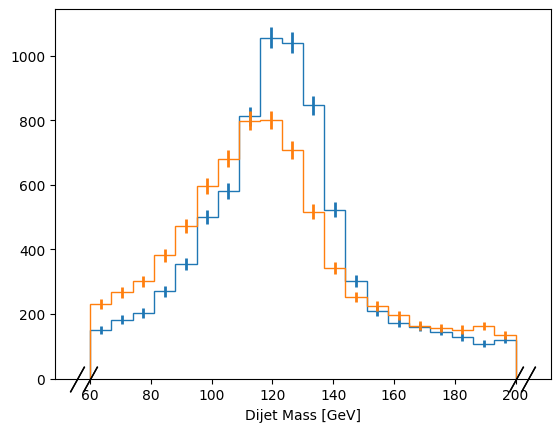

In [9]:
mplhep.histplot(h[{"pair": "0"}])
mplhep.histplot(h[{"pair": "1"}])

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7feaf6218d60>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

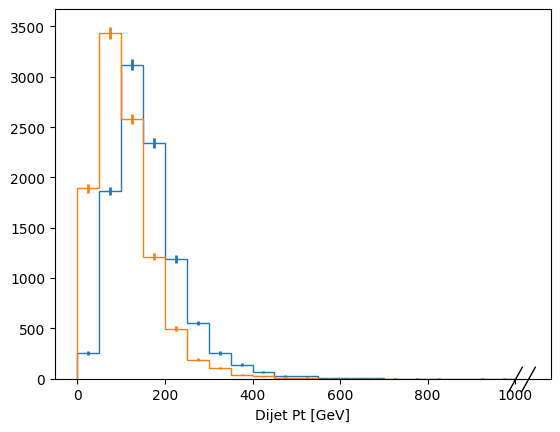

In [10]:
dijet_pt_axis = hist.axis.Regular(20, 0, 1000, name="dijet_pt", label="Dijet Pt [GeV]")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)

h = hist.Hist(dijet_pt_axis, pair_axis)
h.fill(dijet_pt=jetAssignmentDict["ak4DijetPt0"], pair="0")
h.fill(dijet_pt=jetAssignmentDict["ak4DijetPt1"], pair="1")

mplhep.histplot(h[{"pair": "0"}])
mplhep.histplot(h[{"pair": "1"}])

In [11]:
jetAssignmentDict["ak4DijetPt0"]

array([121.12994839,  52.54989542,  85.45180898, ..., 130.62165802,
       105.71452172, 132.26739094])

In [12]:
jetAssignmentDict["ak4DijetPt1"]

array([ 18.08726126,  51.7334611 ,  23.73286696, ...,  24.08015168,
        95.43987159, 130.40055885])

In [13]:
jetAssignmentDict["ak4DijetDeltaR"]

array([1.21828924, 7.08352325, 5.91422441, ..., 1.98211621, 3.35686714,
       2.89492679])

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7feaf5dc3700>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

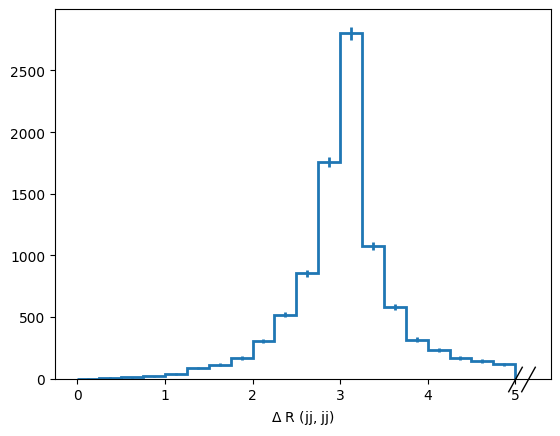

In [14]:
deltar_axis = hist.axis.Regular(20, 0, 5, name="deltar", label=r"$\Delta$ R (jj, jj)")

h = hist.Hist(deltar_axis)
h.fill(deltar=jetAssignmentDict["ak4DijetDeltaR"])

h.plot1d(lw=2)

## Load pre-processed samples

In [15]:
import utils

In [16]:
samples = {
    "hh4b": ["GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8"],
}

# define dictionary with directories of files (this can be configured in a yaml file later in the script)

# this is the directory to the files
path_to_dir = "/eos/uscms/store/user/cmantill/bbbb/matching/Oct10/"
dirs = {path_to_dir: samples}
year = "2018"

filters = None

# dictionary that will contain all information (from all samples)
events_dict = {}
for input_dir, samples in dirs.items():
    events_dict = {
        **events_dict,
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **utils.load_samples(input_dir, samples, year, filters=filters),
    }

samples_loaded = list(events_dict.keys())
keys_loaded = list(events_dict[samples_loaded[0]].keys())
print(f"Keys in events_dict")
for i in keys_loaded: print(i)

Loading GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8
Keys in events_dict
('GenHiggsEta', 0)
('GenHiggsEta', 1)
('GenHiggsPhi', 0)
('GenHiggsPhi', 1)
('GenHiggsMass', 0)
('GenHiggsMass', 1)
('GenHiggsPt', 0)
('GenHiggsPt', 1)
('GenbEta', 0)
('GenbEta', 1)
('GenbEta', 2)
('GenbEta', 3)
('GenbPhi', 0)
('GenbPhi', 1)
('GenbPhi', 2)
('GenbPhi', 3)
('GenbMass', 0)
('GenbMass', 1)
('GenbMass', 2)
('GenbMass', 3)
('GenbPt', 0)
('GenbPt', 1)
('GenbPt', 2)
('GenbPt', 3)
('ak4JetHiggsMatch', 0)
('ak4JetHiggsMatch', 1)
('ak4JetHiggsMatch', 2)
('ak4JetHiggsMatch', 3)
('ak4JetHiggsMatch', 4)
('ak4JetHiggsMatch', 5)
('ak4JetHiggsMatchIndex', 0)
('ak4JetHiggsMatchIndex', 1)
('ak4JetHiggsMatchIndex', 2)
('ak4JetHiggsMatchIndex', 3)
('ak4JetHiggsMatchIndex', 4)
('ak4JetHiggsMatchIndex', 5)
('ak4JethadronFlavour', 0)
('ak4JethadronFlavour', 1)
('ak4JethadronFlavour', 2)
('ak4JethadronFlavour', 3)
('ak4JethadronFlavour', 4)
('ak4JethadronFlavour', 5)
('ak8FatJetHiggsMatch', 0)
('ak8FatJetHi

In [17]:
import pandas as pd

In [18]:
def make_vector(events: pd.DataFrame, obj: str):
    """Create a ``vector`` object from the columns of the dataframe"""
    mstring = "PNetMass" if obj == "ak8FatJet" else "Mass"

    return vector.array(
        {
            "pt": events[f"{obj}Pt"],
            "phi": events[f"{obj}Phi"],
            "eta": events[f"{obj}Eta"],
            "M": events[f"{obj}{mstring}"],
        }
    )

In [19]:
events_dict["hh4b"].ak4Pair0[0].to_numpy()

array([0, 0, 0, ..., 0, 0, 0])

In [20]:
events_dict["hh4b"].ak4Pair0.to_numpy()

array([[0, 3],
       [0, 1],
       [0, 1],
       ...,
       [0, 3],
       [0, 1],
       [0, 1]])

In [21]:
events_dict["hh4b"].ak4Pair0.to_numpy()[:, 0]

array([0, 0, 0, ..., 0, 0, 0])

## Order pairs by pT

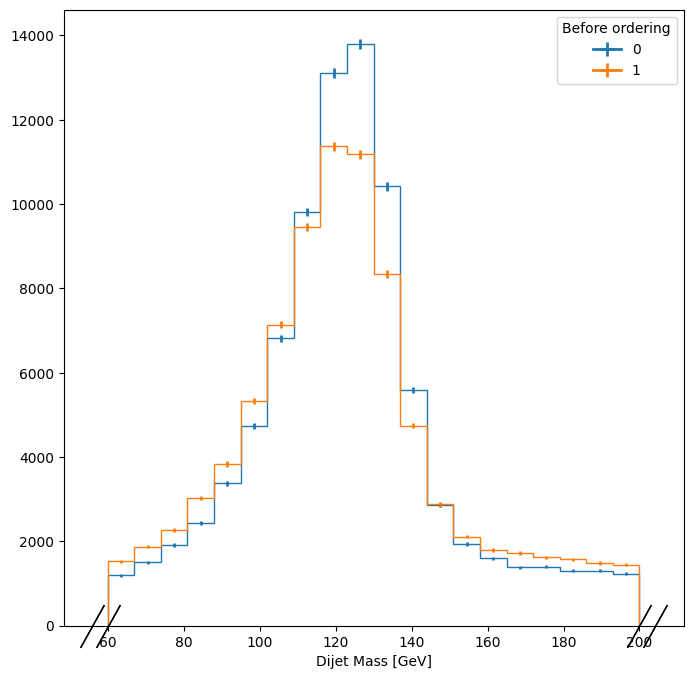

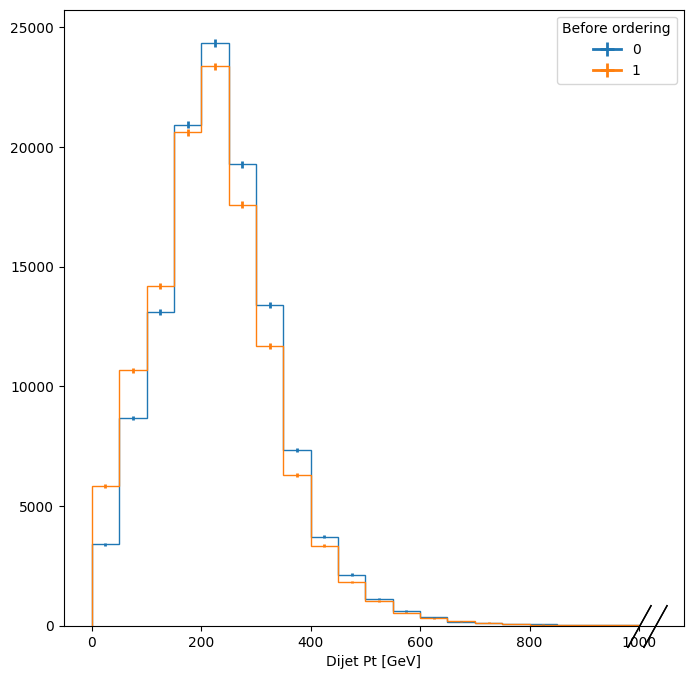

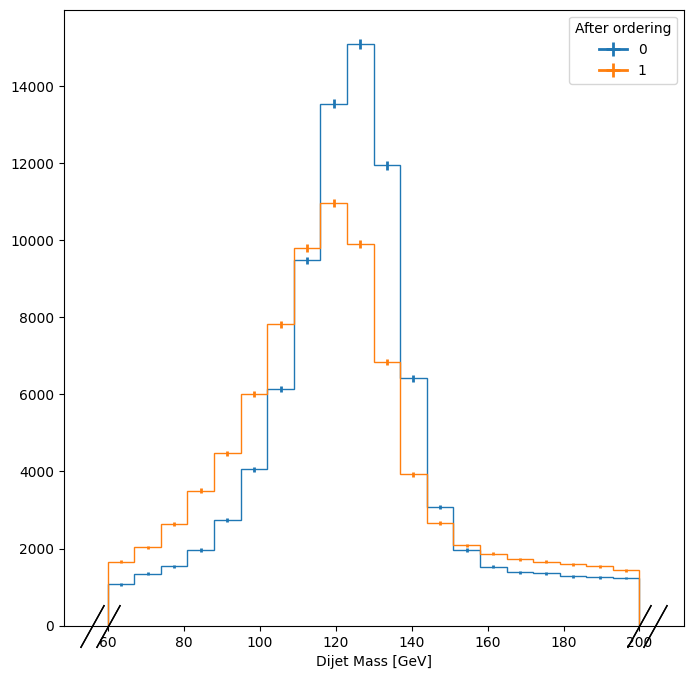

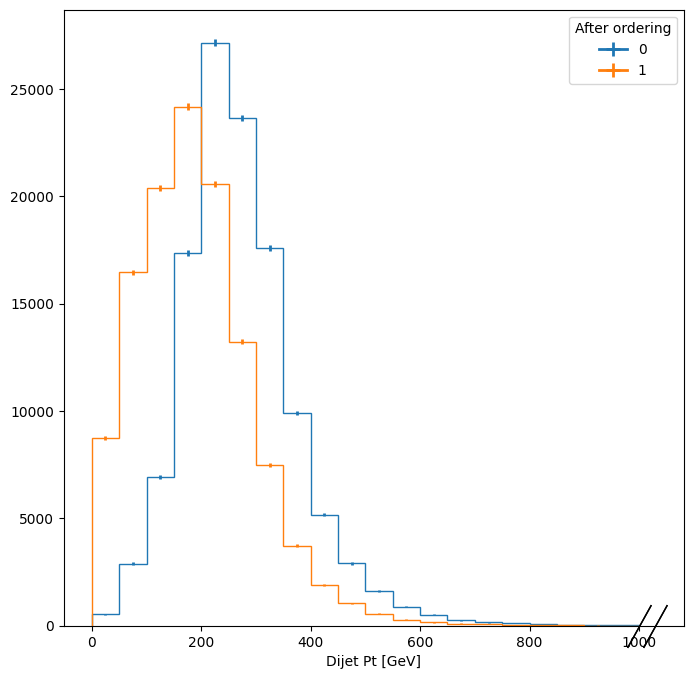

In [22]:
first_bb_pair = events_dict["hh4b"].ak4Pair0.to_numpy()
second_bb_pair = events_dict["hh4b"].ak4Pair1.to_numpy()

jets = make_vector(events_dict["hh4b"], "ak4Jet")
fatjets = make_vector(events_dict["hh4b"], "ak8FatJet")

first_bb_j1 = jets[np.arange(len(jets.pt)), first_bb_pair[:, 0]]
first_bb_j2 = jets[np.arange(len(jets.pt)), first_bb_pair[:, 1]]
first_bb_dijet = first_bb_j1 + first_bb_j2

second_bb_j1 = jets[np.arange(len(jets.pt)), second_bb_pair[:, 0]]
second_bb_j2 = jets[np.arange(len(jets.pt)), second_bb_pair[:, 1]]
second_bb_dijet = second_bb_j1 + second_bb_j2

dijet_mass_axis = hist.axis.Regular(20, 60, 200, name="dijet_mass", label="Dijet Mass [GeV]")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)

h = hist.Hist(dijet_mass_axis, pair_axis)
h.fill(dijet_mass=first_bb_dijet.mass, pair="0")
h.fill(dijet_mass=second_bb_dijet.mass, pair="1")

fig, ax = plt.subplots(figsize=(8, 8))
h[{"pair": "0"}].plot1d(label="0", ax=ax)
h[{"pair": "1"}].plot1d(label="1", ax=ax)
ax.legend(title="Before ordering")

dijet_pt_axis = hist.axis.Regular(20, 0, 1000, name="dijet_pt", label="Dijet Pt [GeV]")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)

h = hist.Hist(dijet_pt_axis, pair_axis)
h.fill(dijet_pt=first_bb_dijet.pt, pair="0")
h.fill(dijet_pt=second_bb_dijet.pt, pair="1")

fig, ax = plt.subplots(figsize=(8, 8))
h[{"pair": "0"}].plot1d(label="0", ax=ax)
h[{"pair": "1"}].plot1d(label="1", ax=ax)
ax.legend(title="Before ordering")

# stack pairs
bb_pairs = np.stack([first_bb_pair, second_bb_pair], axis=1)

# sort by dijet pt
bbs_jjpt = np.concatenate(
    [first_bb_dijet.pt.reshape(-1, 1), second_bb_dijet.pt.reshape(-1, 1)], axis=1
)
sort_by_jjpt = np.argsort(bbs_jjpt, axis=-1)[:, ::-1]

bb_pairs_sorted = np.array(
    [
        [bb_pair_e[sort_e[0]], bb_pair_e[sort_e[1]]]
        for bb_pair_e, sort_e in zip(bb_pairs, sort_by_jjpt)
    ]
)

first_bb_pair_sort = bb_pairs_sorted[:, 0]
second_bb_pair_sort = bb_pairs_sorted[:, 1]

first_bb_j1 = jets[np.arange(len(jets.pt)), first_bb_pair_sort[:, 0]]
first_bb_j2 = jets[np.arange(len(jets.pt)), first_bb_pair_sort[:, 1]]
first_bb_dijet = first_bb_j1 + first_bb_j2

second_bb_j1 = jets[np.arange(len(jets.pt)), second_bb_pair_sort[:, 0]]
second_bb_j2 = jets[np.arange(len(jets.pt)), second_bb_pair_sort[:, 1]]
second_bb_dijet = second_bb_j1 + second_bb_j2

dijet_mass_axis = hist.axis.Regular(20, 60, 200, name="dijet_mass", label="Dijet Mass [GeV]")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)

h = hist.Hist(dijet_mass_axis, pair_axis)
h.fill(dijet_mass=first_bb_dijet.mass, pair="0")
h.fill(dijet_mass=second_bb_dijet.mass, pair="1")

fig, ax = plt.subplots(figsize=(8, 8))
h[{"pair": "0"}].plot1d(label="0", ax=ax)
h[{"pair": "1"}].plot1d(label="1", ax=ax)
ax.legend(title="After ordering")

dijet_pt_axis = hist.axis.Regular(20, 0, 1000, name="dijet_pt", label="Dijet Pt [GeV]")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)

h = hist.Hist(dijet_pt_axis, pair_axis)
h.fill(dijet_pt=first_bb_dijet.pt, pair="0")
h.fill(dijet_pt=second_bb_dijet.pt, pair="1")

fig, ax = plt.subplots(figsize=(8, 8))
h[{"pair": "0"}].plot1d(label="0", ax=ax)
h[{"pair": "1"}].plot1d(label="1", ax=ax)
ax.legend(title="After ordering")

### Get delta R between pairs

Text(0.5, 1.0, '$\\Delta R$ between pairs')

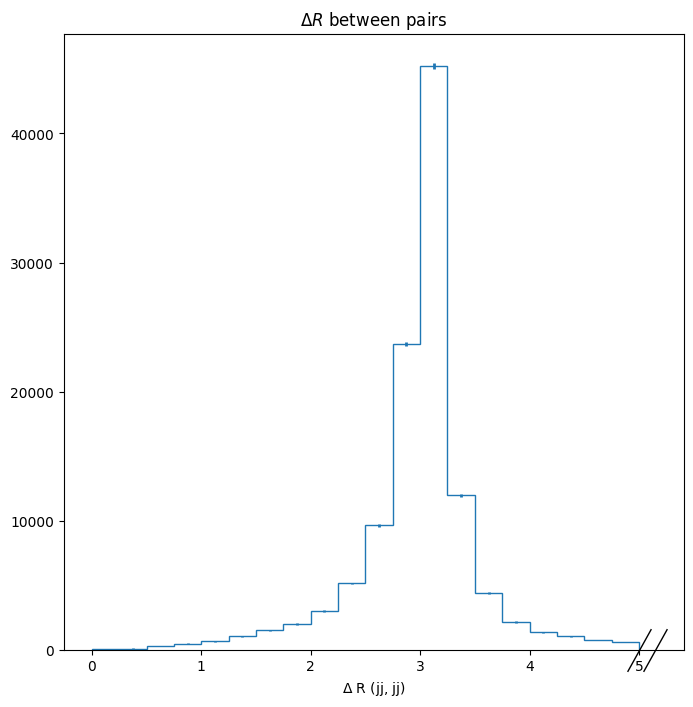

In [23]:
deltar_axis = hist.axis.Regular(20, 0, 5, name="deltar", label=r"$\Delta$ R (jj, jj)")
h = hist.Hist(deltar_axis)
h.fill(deltar=first_bb_dijet.deltaR(second_bb_dijet))

fig, ax = plt.subplots(figsize=(8, 8))
h.plot1d()
ax.set_title(r"$\Delta R$ between pairs")

## Order pairs by dR

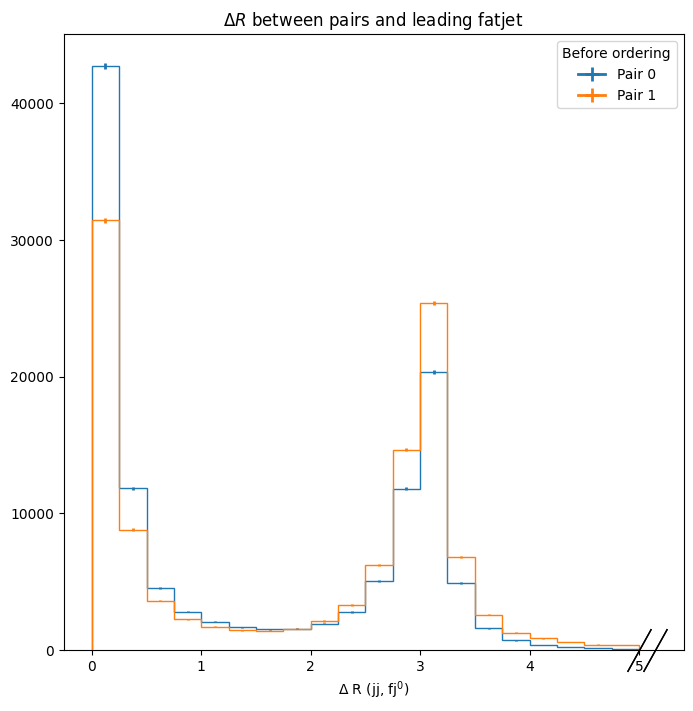

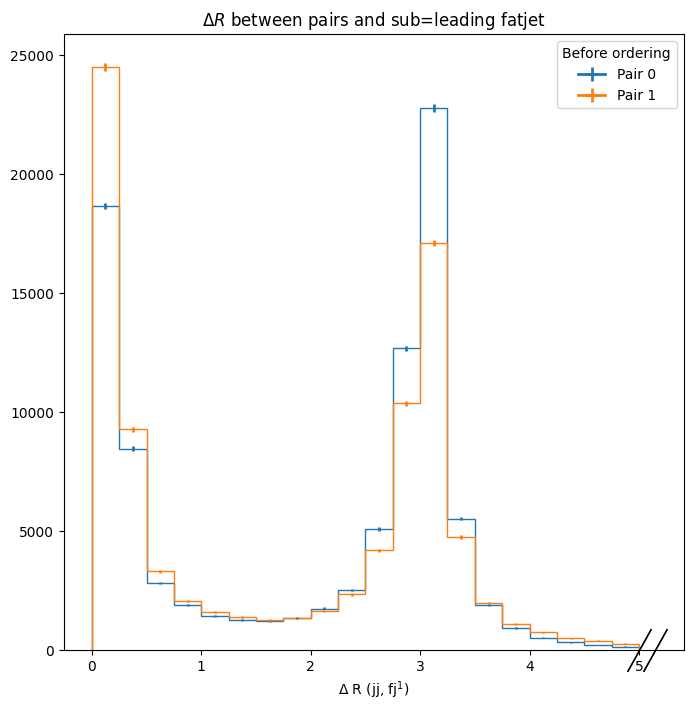

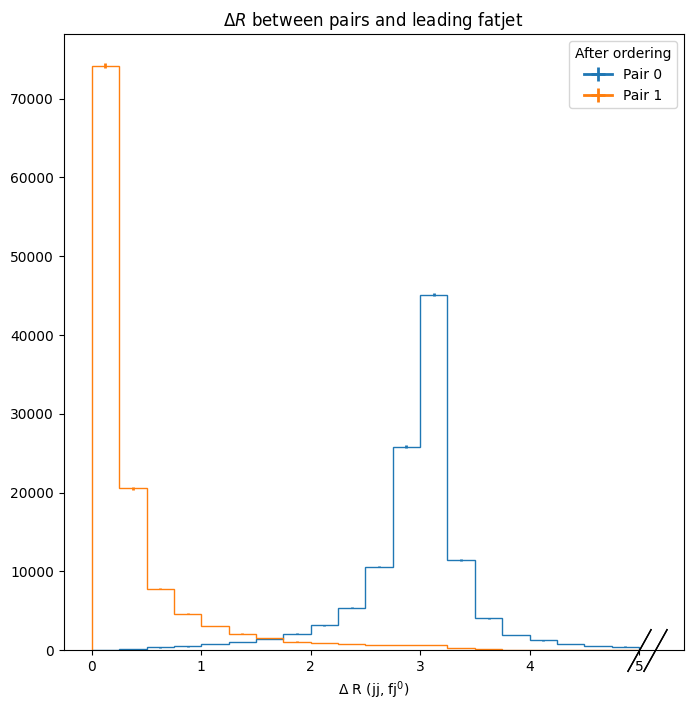

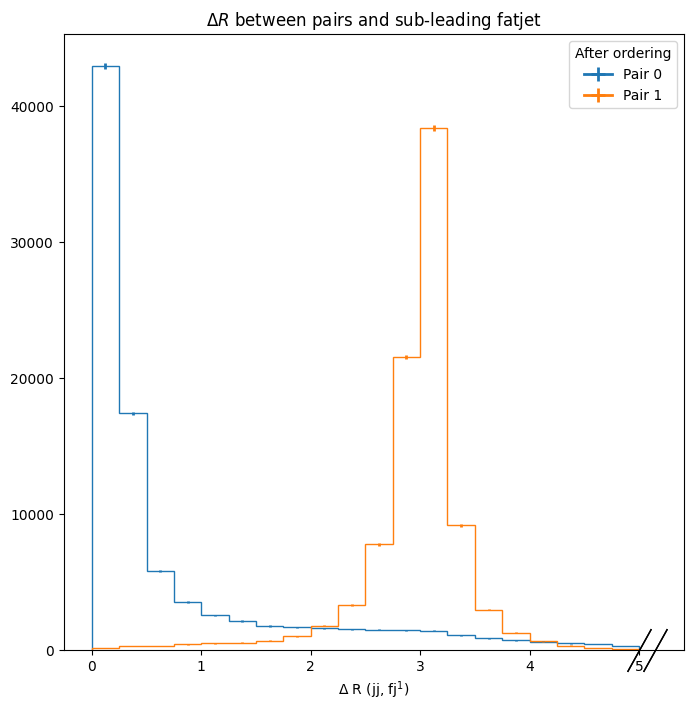

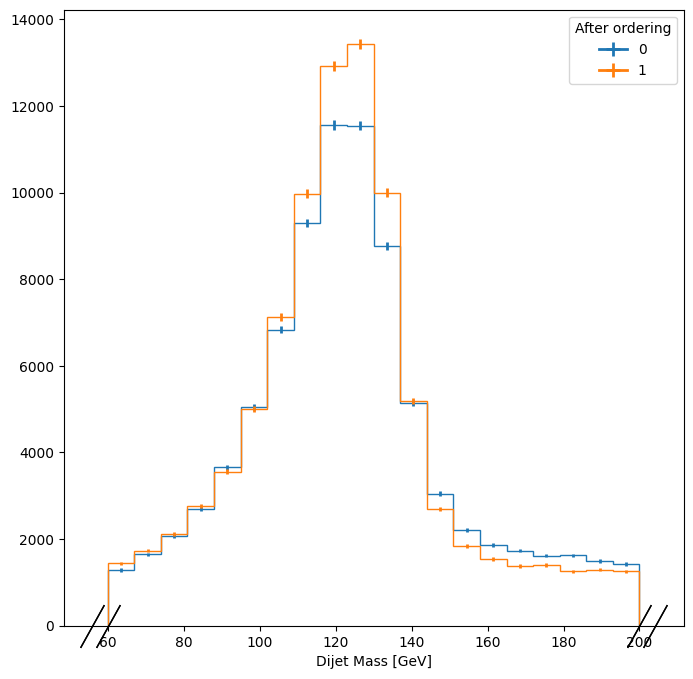

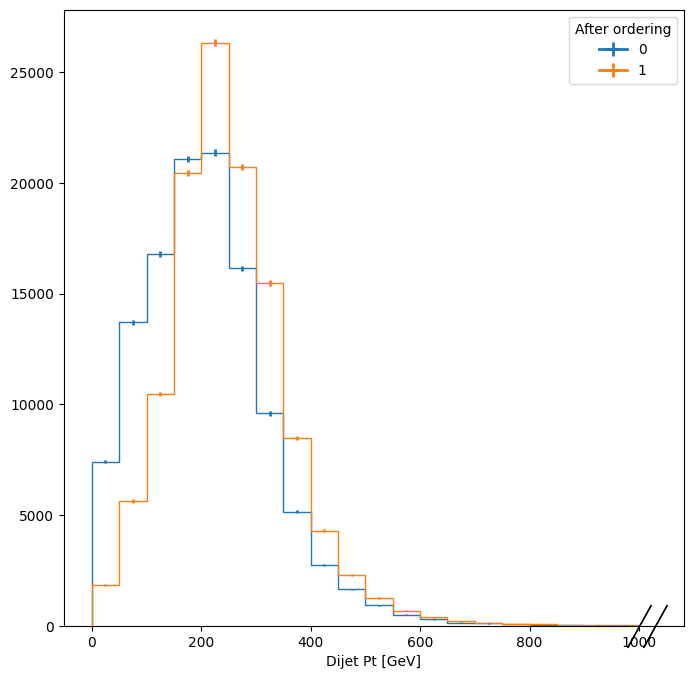

In [24]:
jets = make_vector(events_dict["hh4b"], "ak4Jet")
fatjets = make_vector(events_dict["hh4b"], "ak8FatJet")

fatjet_0 = fatjets[:, 0]

first_bb_pair = events_dict["hh4b"].ak4Pair0.to_numpy()
second_bb_pair = events_dict["hh4b"].ak4Pair1.to_numpy()
first_bb_j1 = jets[np.arange(len(jets.pt)), first_bb_pair[:, 0]]
first_bb_j2 = jets[np.arange(len(jets.pt)), first_bb_pair[:, 1]]
first_bb_dijet = first_bb_j1 + first_bb_j2

second_bb_j1 = jets[np.arange(len(jets.pt)), second_bb_pair[:, 0]]
second_bb_j2 = jets[np.arange(len(jets.pt)), second_bb_pair[:, 1]]
second_bb_dijet = second_bb_j1 + second_bb_j2

# get delta r between pairs and fatjets
fatjet_0 = fatjets[:, 0]
fatjet_1 = fatjets[:, 1]

deltar_axis = hist.axis.Regular(20, 0, 5, name="deltar", label=r"$\Delta$ R (jj, fj$^0$)")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)
h = hist.Hist(deltar_axis, pair_axis)
h.fill(deltar=first_bb_dijet.deltaR(fatjet_0), pair="0")
h.fill(deltar=second_bb_dijet.deltaR(fatjet_0), pair="1")

fig, ax = plt.subplots(figsize=(8, 8))
h[{"pair": 0}].plot1d(label="Pair 0", ax=ax)
h[{"pair": 1}].plot1d(label="Pair 1", ax=ax)
ax.set_title(r"$\Delta R$ between pairs and leading fatjet")
ax.legend(title="Before ordering")

deltar_axis = hist.axis.Regular(20, 0, 5, name="deltar", label=r"$\Delta$ R (jj, fj$^1$)")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)
h = hist.Hist(deltar_axis, pair_axis)
h.fill(deltar=first_bb_dijet.deltaR(fatjet_1), pair="0")
h.fill(deltar=second_bb_dijet.deltaR(fatjet_1), pair="1")

fig, ax = plt.subplots(figsize=(8, 8))
h[{"pair": 0}].plot1d(label="Pair 0", ax=ax)
h[{"pair": 1}].plot1d(label="Pair 1", ax=ax)
ax.set_title(r"$\Delta R$ between pairs and sub=leading fatjet")
ax.legend(title="Before ordering")

# stack pairs
bb_pairs = np.stack([first_bb_pair, second_bb_pair], axis=1)

# sort by deltaR with leading fatjet
bbs_dRfj = np.concatenate(
    [
        first_bb_dijet.deltaR(fatjet_0).reshape(-1, 1),
        second_bb_dijet.deltaR(fatjet_0).reshape(-1, 1),
    ],
    axis=1,
)
# sort from larger dR to smaller
sort_by_dR = np.argsort(-bbs_dRfj, axis=-1)

bb_pairs_sorted = np.array(
    [
        [bb_pair_e[sort_e[0]], bb_pair_e[sort_e[1]]]
        for bb_pair_e, sort_e in zip(bb_pairs, sort_by_dR)
    ]
)

first_bb_pair_sort = bb_pairs_sorted[:, 0]
second_bb_pair_sort = bb_pairs_sorted[:, 1]


first_bb_j1 = jets[np.arange(len(jets.pt)), first_bb_pair_sort[:, 0]]
first_bb_j2 = jets[np.arange(len(jets.pt)), first_bb_pair_sort[:, 1]]
first_bb_dijet = first_bb_j1 + first_bb_j2

second_bb_j1 = jets[np.arange(len(jets.pt)), second_bb_pair_sort[:, 0]]
second_bb_j2 = jets[np.arange(len(jets.pt)), second_bb_pair_sort[:, 1]]
second_bb_dijet = second_bb_j1 + second_bb_j2

# get delta r between pairs and fatjets
fatjet_0 = fatjets[:, 0]
fatjet_1 = fatjets[:, 1]

deltar_axis = hist.axis.Regular(20, 0, 5, name="deltar", label=r"$\Delta$ R (jj, fj$^0$)")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)
h = hist.Hist(deltar_axis, pair_axis)
h.fill(deltar=first_bb_dijet.deltaR(fatjet_0), pair="0")
h.fill(deltar=second_bb_dijet.deltaR(fatjet_0), pair="1")

fig, ax = plt.subplots(figsize=(8, 8))
h[{"pair": 0}].plot1d(label="Pair 0", ax=ax)
h[{"pair": 1}].plot1d(label="Pair 1", ax=ax)
ax.set_title(r"$\Delta R$ between pairs and leading fatjet")
ax.legend(title="After ordering")

deltar_axis = hist.axis.Regular(20, 0, 5, name="deltar", label=r"$\Delta$ R (jj, fj$^1$)")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)
h = hist.Hist(deltar_axis, pair_axis)
h.fill(deltar=first_bb_dijet.deltaR(fatjet_1), pair="0")
h.fill(deltar=second_bb_dijet.deltaR(fatjet_1), pair="1")

fig, ax = plt.subplots(figsize=(8, 8))
h[{"pair": 0}].plot1d(label="Pair 0", ax=ax)
h[{"pair": 1}].plot1d(label="Pair 1", ax=ax)
ax.set_title(r"$\Delta R$ between pairs and sub-leading fatjet")
ax.legend(title="After ordering")

dijet_mass_axis = hist.axis.Regular(20, 60, 200, name="dijet_mass", label="Dijet Mass [GeV]")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)

h = hist.Hist(dijet_mass_axis, pair_axis)
h.fill(dijet_mass=first_bb_dijet.mass, pair="0")
h.fill(dijet_mass=second_bb_dijet.mass, pair="1")

fig, ax = plt.subplots(figsize=(8, 8))
h[{"pair": "0"}].plot1d(label="0", ax=ax)
h[{"pair": "1"}].plot1d(label="1", ax=ax)
ax.legend(title="After ordering")

dijet_pt_axis = hist.axis.Regular(20, 0, 1000, name="dijet_pt", label="Dijet Pt [GeV]")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)

h = hist.Hist(dijet_pt_axis, pair_axis)
h.fill(dijet_pt=first_bb_dijet.pt, pair="0")
h.fill(dijet_pt=second_bb_dijet.pt, pair="1")

fig, ax = plt.subplots(figsize=(8, 8))
h[{"pair": "0"}].plot1d(label="0", ax=ax)
h[{"pair": "1"}].plot1d(label="1", ax=ax)
ax.legend(title="After ordering")

### Mass resolution

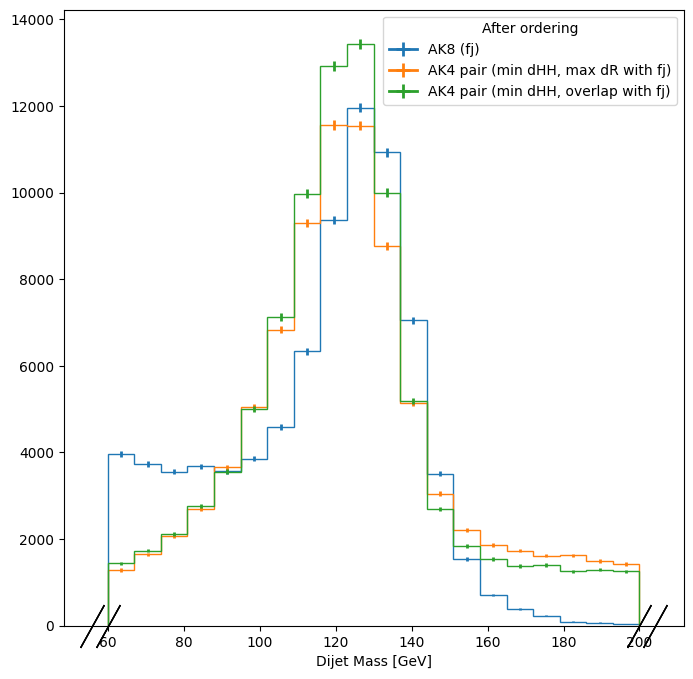

In [25]:
hh_mass_axis = hist.axis.Regular(20, 60, 200, name="hh_mass", label="HH reconstructed mass [GeV]")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)

h = hist.Hist(dijet_mass_axis, pair_axis)
h.fill(dijet_mass=first_bb_dijet.mass, pair="0")
h.fill(dijet_mass=second_bb_dijet.mass, pair="1")
h.fill(dijet_mass=fatjet_0.mass, pair="fj")
h.fill(dijet_mass=fatjet_1.mass, pair="fj2")


fig, ax = plt.subplots(figsize=(8, 8))
h[{"pair": "fj"}].plot1d(label="AK8 (fj)", ax=ax)
# h[{"pair": "fj2"}].plot1d(label="AK8 (fj2)", ax=ax)
h[{"pair": "0"}].plot1d(label="AK4 pair (min dHH, max dR with fj)", ax=ax)
h[{"pair": "1"}].plot1d(label="AK4 pair (min dHH, overlap with fj)", ax=ax)
ax.legend(title="After ordering")

In [26]:
x = np.where(bbs_dRfj > 0.8, bbs_dRfj, 0)
x[np.all(x == 0, axis=1)].shape

(569, 2)

In [27]:
sort_by_dR

array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [28]:
# choice of pair
dr_fatjet = first_bb_dijet.deltaR(fatjet_0)
mask_overlap = dr_fatjet > 0.8

print(dr_fatjet.shape)
print(dr_fatjet[mask_overlap].shape)

(118925,)
(118356,)


### Reconstructed mass

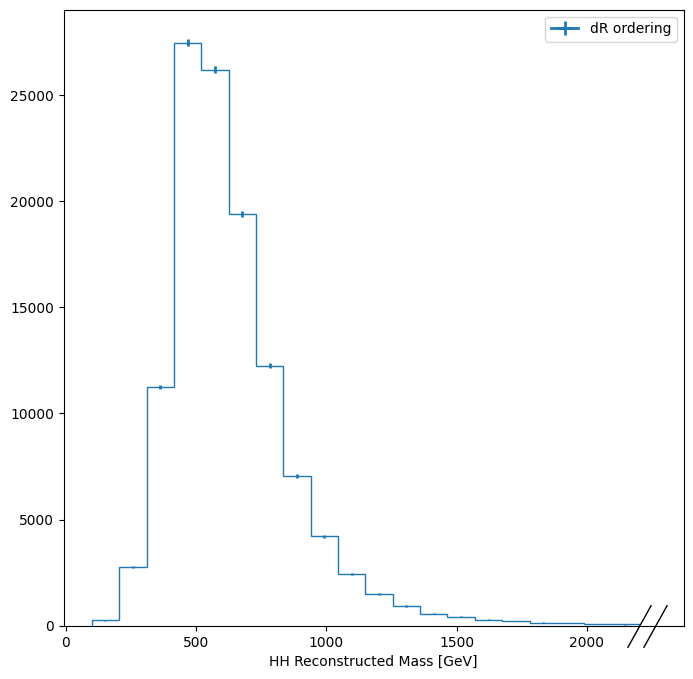

In [29]:
hh = (fatjet_0 + first_bb_dijet)

hh_mass_axis = hist.axis.Regular(20, 100, 2200, name="hh_mass", label="HH Reconstructed Mass [GeV]")

h = hist.Hist(hh_mass_axis)
h.fill(hh_mass=hh.mass)

fig, ax = plt.subplots(figsize=(8, 8))
h.plot1d(label="dR ordering", ax=ax)
ax.legend()

## Pairing efficiency

In [30]:
gen_higgs = make_vector(events_dict["hh4b"], "GenHiggs")
gen_bs = make_vector(events_dict["hh4b"], "Genb")
h1 = gen_higgs[:, 0]
h2 = gen_higgs[:, 1]

# calculate m_HH for every event
mhh = (h1 + h2).m

# mHH from reco
mhh_reco = (first_bb_dijet + fatjet_0).m

# match selected ak4 jets to H
ak4drH1b1 = first_bb_dijet.deltaR(gen_bs[:, 0])
ak4drH1b2 = first_bb_dijet.deltaR(gen_bs[:, 1])
ak4drH2b1 = first_bb_dijet.deltaR(gen_bs[:, 2])
ak4drH2b1 = first_bb_dijet.deltaR(gen_bs[:, 3])
ak4drH = np.stack([ak4drH1b1, ak4drH1b2, ak4drH2b1, ak4drH2b1], axis=1)
ak4Hindex = np.floor(np.argmin(ak4drH, axis=-1) / 2)

# match selected ak8 jets to H
ak8drH1 = fatjet_0.deltaR(h1)
ak8drH2 = fatjet_0.deltaR(h2)
ak8drH = np.stack([ak8drH1, ak8drH2], axis=1)
ak8Hindex = np.argmin(ak8drH, axis=-1)

# masks
matchedak4 = np.any(ak4drH < 0.4, axis=1)
matchedak8 = np.any(ak8drH < 0.8, axis=1)

mhh_matched = mhh[matchedak4 & matchedak8]


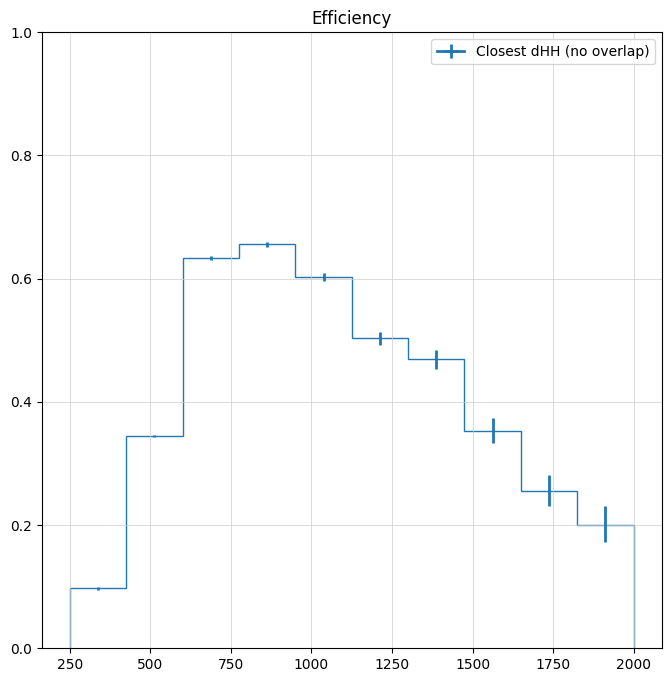

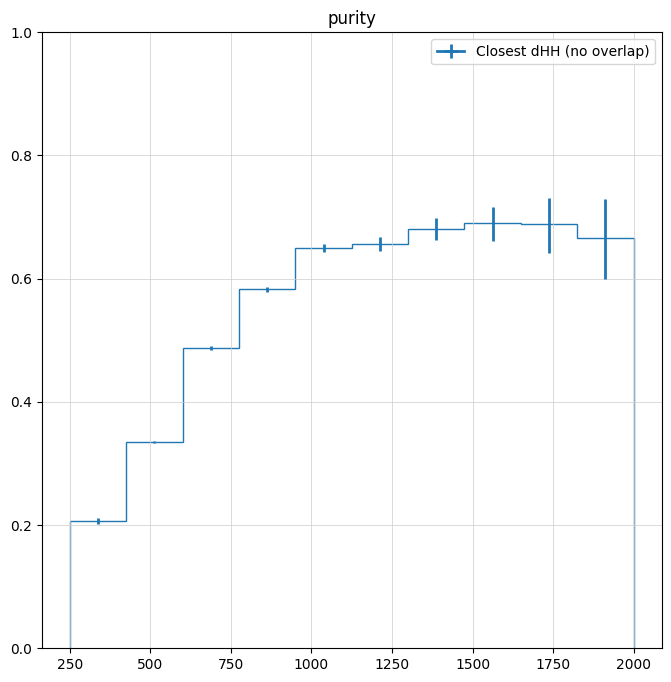

In [31]:
# calculate efficiency and purity for each event

hh_axis = hist.axis.Regular(10, 250, 2000, name="hh_mass", label="HH Mass [GeV]")
from hist.intervals import clopper_pearson_interval

# efficiency
# N reconstructed H bosons matched to gen / N reconstructed Higgs bosons
h = hist.Hist(hh_axis)
h.fill(hh_mass=mhh_matched)

h_denom = hist.Hist(hh_axis)
h_denom.fill(hh_mass=mhh_reco)

efficiency = h/h_denom
edges, counts = efficiency.to_numpy()

fig, ax = plt.subplots(figsize=(8, 8))
yerr = abs(clopper_pearson_interval(h.view(), h_denom.view())- h.view() / h_denom.view())
mplhep.histplot(edges, counts, label="Closest dHH (no overlap)", yerr=yerr)
ax.set_title("Efficiency")
ax.grid()
ax.set_ylim(0,1)
ax.legend()

# purity 
# N reconstructed H bosons matched to gen / N gen Higgs bosons


h_denom = hist.Hist(hh_axis)
h_denom.fill(hh_mass=mhh)

purity = h/h_denom
edges, counts = purity.to_numpy()
yerr = abs(clopper_pearson_interval(h.view(), h_denom.view())- h.view() / h_denom.view())

fig, ax = plt.subplots(figsize=(8, 8))
mplhep.histplot(edges, counts, label="Closest dHH (no overlap)", yerr=yerr)
ax.set_title("purity")
ax.grid()
ax.set_ylim(0,1)
ax.legend()
